Import libraries

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import mplcursors
%matplotlib widget



Constants

In [35]:
########################################
# Session-specific config
########################################

# Path to the raw session CSV you recorded from the watch
INPUT_CSV = "../raw_sessions/serve_raw.csv"

# A unique ID for this session (matches naming convention)
SESSION_ID = "serves_watch-right"

# Semantic label for all swings in this session
STROKE_LABEL = "serve"  # later you'll do "serve", "serve", etc.

# Context/notes about how swings were collected (used in metadata)
CONTEXT = "drill_serves_shadow"

########################################
# Physical / device config
########################################
SAMPLING_PERIOD_MS = 10        # 10 ms between samples
SAMPLING_HZ = 100              # 100 Hz
WATCH_SIDE = "right"           # watch worn on right wrist

########################################
# Segmentation export params
########################################
BUFFER_MS_EACH_SIDE = 200   # include 200ms padding before & after the segment
BUFFER_SAMPLES = int(np.ceil(BUFFER_MS_EACH_SIDE / SAMPLING_PERIOD_MS))

# Where processed data lives
CONT_OUT_DIR = "../processed/continuous_isSwing"
SEGMENT_OUT_BASEDIR = "../processed/swings_segments"
METADATA_PATH = "../processed/swings_metadata.csv"

# Make sure output dirs exist
os.makedirs(CONT_OUT_DIR, exist_ok=True)
os.makedirs(SEGMENT_OUT_BASEDIR, exist_ok=True)
os.makedirs("../processed", exist_ok=True)

Exploratory Analysis

In [36]:
#Calculate the magnitude of the angular velocity vector
df = pd.read_csv(INPUT_CSV)

required_cols = ['rotationRateX', 'rotationRateY', 'rotationRateZ']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column '{c}' in input CSV")

# If timestamp column doesn't exist, create a sample index-based time (ms)
if 'timestamp' not in df.columns:
    # We'll fabricate a timestamp column in milliseconds from start
    df['timestamp'] = np.arange(len(df)) * SAMPLING_PERIOD_MS

# Compute omega_mag if not already present
if 'omega_mag' not in df.columns:
    df['omega_mag'] = np.sqrt(
        df['rotationRateX']**2 +
        df['rotationRateY']**2 +
        df['rotationRateZ']**2
    )

df.head()

,time,seconds_elapsed,rotationRateX,rotationRateY,rotationRateZ,gravityX,gravityY,gravityZ,accelerationX,accelerationY,accelerationZ,quaternionW,quaternionX,quaternionY,quaternionZ,pitch,roll,yaw,timestamp,omega_mag
0,1761597263507122432,6.738122,-0.159392,0.047775,-0.624438,-0.542643,0.596607,-0.591268,0.172404,0.337231,-0.112849,0.208638,0.217517,-0.396299,0.867240,-0.639267,-0.742542,2.413105,0,0.646228
1,1761597263517167360,6.748167,-0.048635,0.166234,-0.677271,-0.545876,0.593703,-0.591216,0.263146,0.335832,-0.142549,0.212073,0.218093,-0.396014,0.866391,-0.635653,-0.745546,2.405585,10,0.699068
2,1761597263527213312,6.758213,0.060001,0.201399,-0.703275,-0.548864,0.589842,-0.592314,0.218007,0.225176,-0.173678,0.215861,0.218466,-0.395115,0.865772,-0.630863,-0.747342,2.398383,20,0.734001
3,1761597263537259264,6.768259,0.072905,0.135776,-0.682431,-0.551951,0.585566,-0.593686,0.129313,0.108358,-0.160022,0.219503,0.219016,-0.393940,0.865252,-0.625578,-0.748984,2.391835,30,0.699616
4,1761597263547305472,6.778305,-0.079267,0.131252,-0.658662,-0.555106,0.581821,-0.594426,0.076453,0.063443,-0.179760,0.223037,0.219612,-0.393138,0.864562,-0.620966,-0.751206,2.384940,40,0.676274


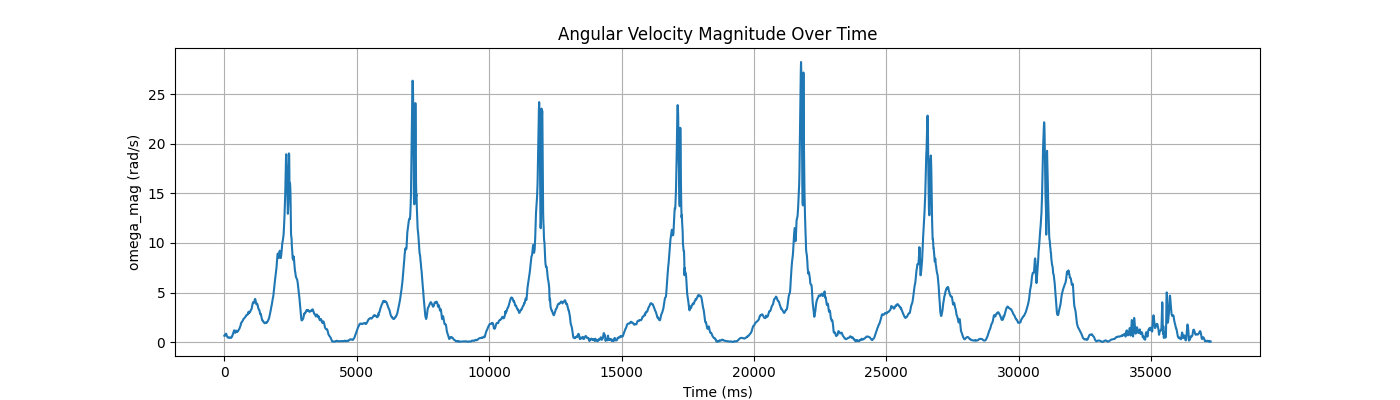

In [37]:
plt.figure(figsize=(14,4))
plt.plot(df['timestamp'], df['omega_mag'])
plt.xlabel("Time (ms)")
plt.ylabel("omega_mag (rad/s)")
plt.title("Angular Velocity Magnitude Over Time")
plt.grid(True)
plt.show()


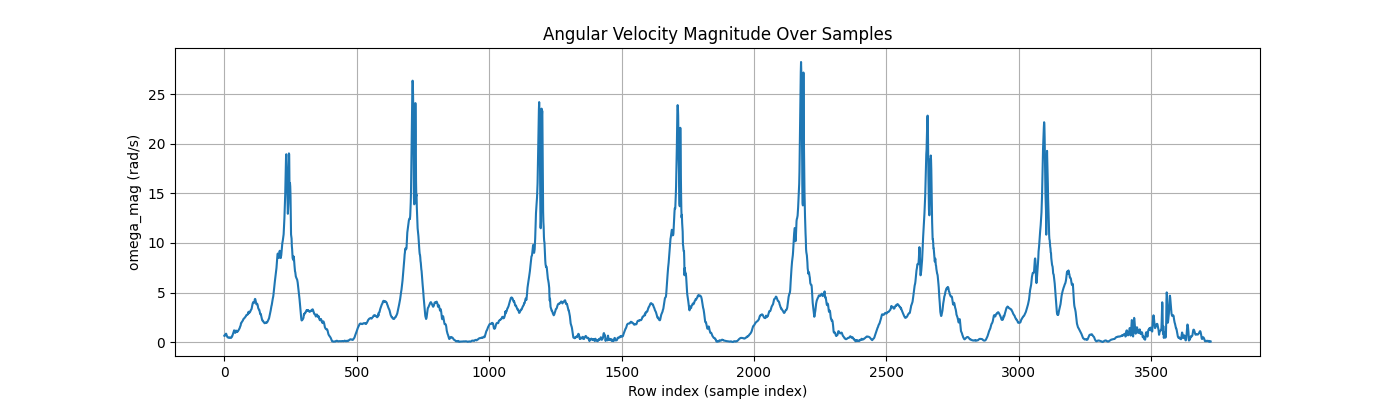

/var/folders/93/m7f8k_7s2n7_vmxxj8gv1kq80000gn/T/ipykernel_20166/970281867.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14,4))


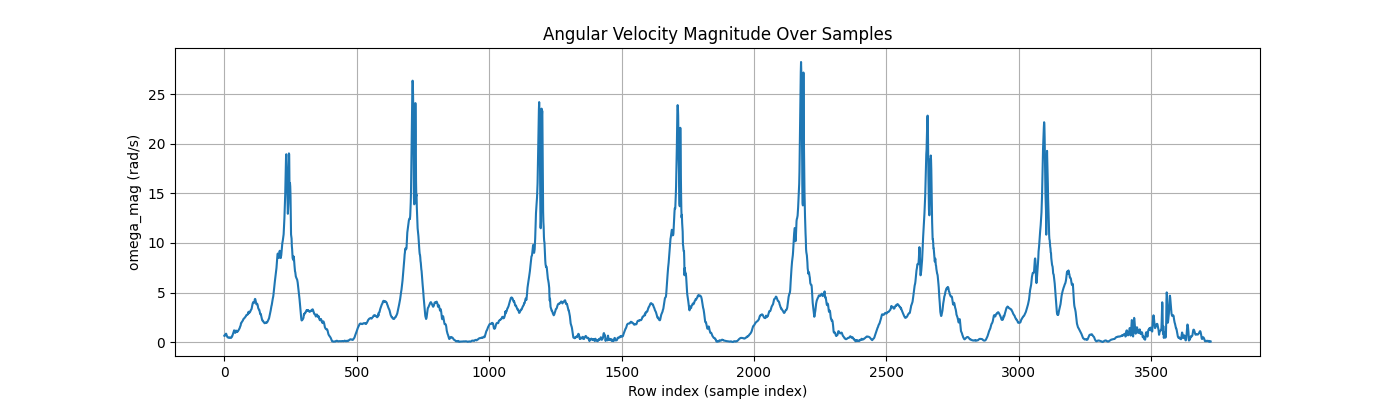

In [38]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df['omega_mag'])
plt.xlabel("Row index (sample index)")
plt.ylabel("omega_mag (rad/s)")
plt.title("Angular Velocity Magnitude Over Samples")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df.index, df['omega_mag'])
plt.xlabel("Row index (sample index)")
plt.ylabel("omega_mag (rad/s)")
plt.title("Angular Velocity Magnitude Over Samples")
plt.grid(True)
plt.show()



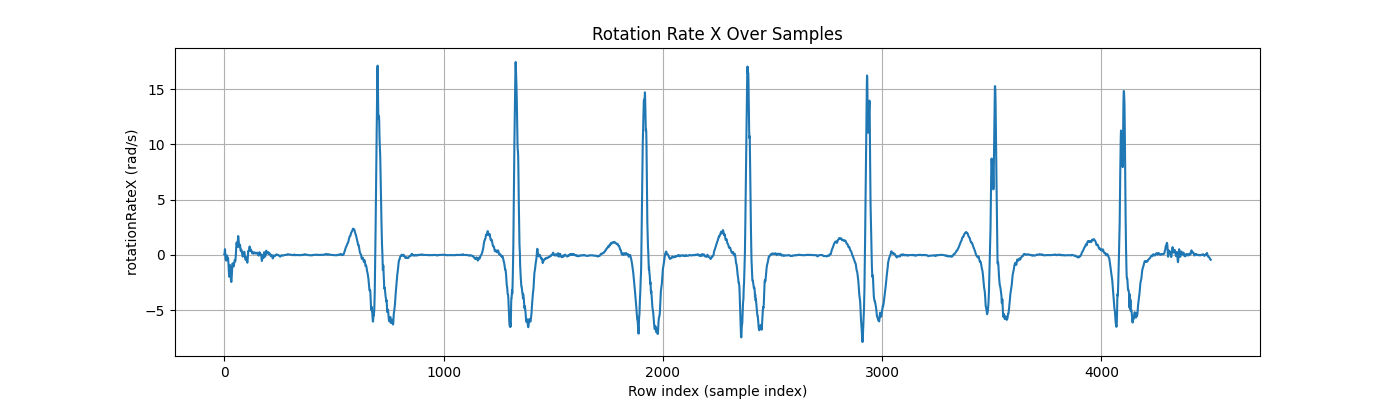

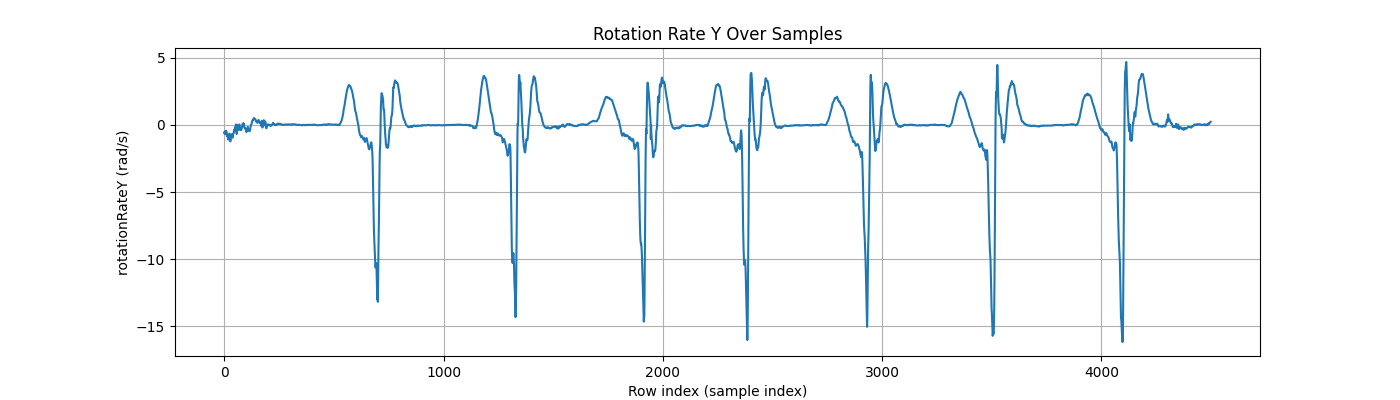

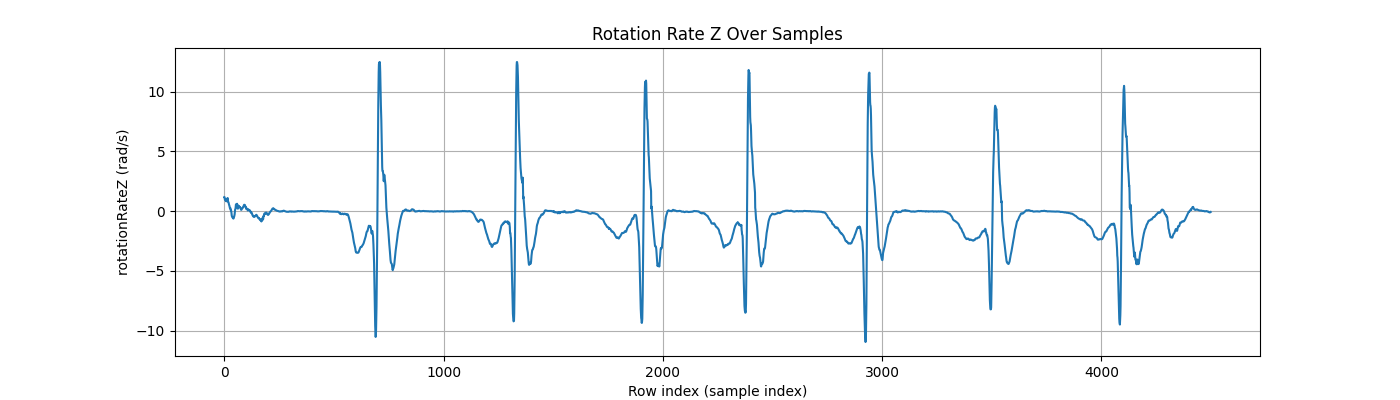

In [27]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df['rotationRateX'])
plt.xlabel("Row index (sample index)")
plt.ylabel("rotationRateX (rad/s)")
plt.title("Rotation Rate X Over Samples")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df.index, df['rotationRateY'])
plt.xlabel("Row index (sample index)")
plt.ylabel("rotationRateY (rad/s)")
plt.title("Rotation Rate Y Over Samples")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df.index, df['rotationRateZ'])
plt.xlabel("Row index (sample index)")
plt.ylabel("rotationRateZ (rad/s)")
plt.title("Rotation Rate Z Over Samples")
plt.grid(True)
plt.show()


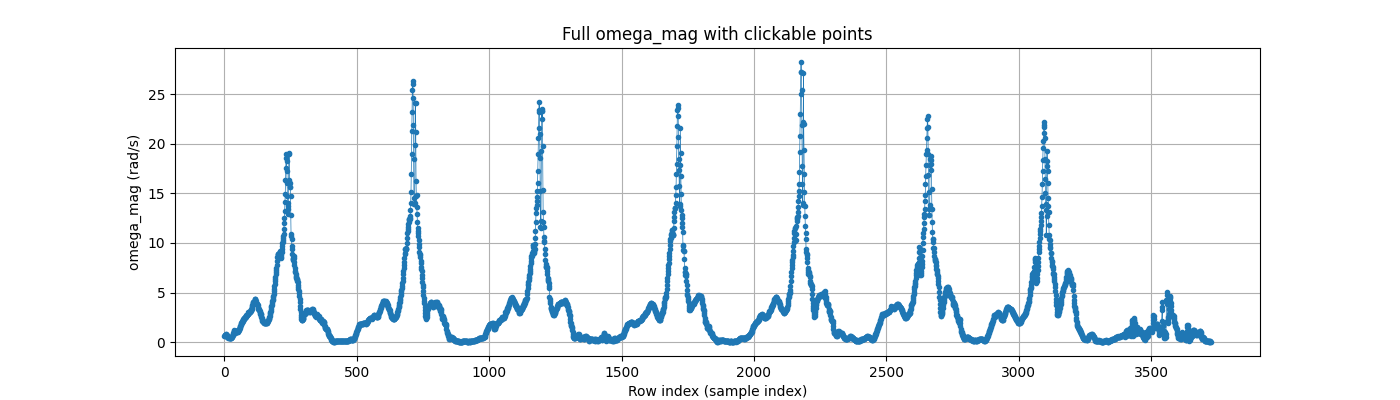

In [39]:


fig, ax = plt.subplots(figsize=(14,4))
line = ax.plot(df.index, df['omega_mag'], marker='.', linewidth=0.5)[0]

ax.set_title("Full omega_mag with clickable points")
ax.set_xlabel("Row index (sample index)")
ax.set_ylabel("omega_mag (rad/s)")
ax.grid(True)

cursor = mplcursors.cursor(line, hover=True)

@cursor.connect("add")
def _(sel):
    idx = int(sel.index)
    sel.annotation.set_text(
        f"idx={idx}\nomega={df['omega_mag'].iloc[idx]:.2f}\nms={df['timestamp'].iloc[idx]}"
    )
    print("Picked index:", idx)

plt.show()

In [41]:
# Visually inspected
# swing_segments_forehand = [(402, 902), (1093, 1531), (1635, 2083), (2150, 2564), (2680, 3110), (3264, 3721), (3834, 4283)]
swing_segments = [(25, 440), (447, 889), (953, 1344), (1482, 1888), (1932, 2393), (2453, 2811), (2870, 3253)]


Helper Functions

In [42]:
def add_isSwing_column(df, swing_runs):
    """
    swing_runs: list of (start_idx, end_idx) in raw df index coordinates (no padding yet)
    We'll mark df['isSwing'] = 1 between those indices, else 0.
    Note: We'll clamp indices to valid range.
    """
    isSwing = np.zeros(len(df), dtype=int)
    for (start, end) in swing_runs:
        start_clamped = max(start, 0)
        end_clamped = min(end, len(df))
        isSwing[start_clamped:end_clamped] = 1
    df = df.copy()
    df['isSwing'] = isSwing
    return df

df_with_isSwing = add_isSwing_column(df, swing_segments)
df_with_isSwing.head()

cont_outfile = os.path.join(
    CONT_OUT_DIR,
    f"{SESSION_ID}_isSwing.csv"
)

df_with_isSwing.to_csv(cont_outfile, index=False)
print("Wrote continuous labeled timeline to:", cont_outfile)

cont_outfile = os.path.join(
    CONT_OUT_DIR,
    f"{SESSION_ID}_isSwing.csv"
)

df_with_isSwing.to_csv(cont_outfile, index=False)
print("Wrote continuous labeled timeline to:", cont_outfile)



Wrote continuous labeled timeline to: ../processed/continuous_isSwing/serves_watch-right_isSwing.csv
Wrote continuous labeled timeline to: ../processed/continuous_isSwing/serves_watch-right_isSwing.csv


Export each swing as its own CSV

In [43]:
def extract_segment_with_buffer(df, start_idx, end_idx, buffer_samples):
    """
    Take a segment [start_idx, end_idx),
    expand it by buffer_samples on both sides,
    clamp to valid range,
    and return the sliced dataframe.
    """
    start_buf = max(start_idx - buffer_samples, 0)
    end_buf = min(end_idx + buffer_samples, len(df))
    seg = df.iloc[start_buf:end_buf].copy()
    return seg, start_buf, end_buf

def build_segment_df(seg_df, session_id, label, sampling_period_ms):
    """
    seg_df: dataframe slice for ONE swing (already buffered)
    Adds:
    - t_rel_ms (0, 10, 20, ...)
    - label (stroke type)
    - session_id
    """
    t_rel_ms = np.arange(len(seg_df)) * sampling_period_ms
    seg_df = seg_df.copy()
    seg_df.insert(0, 't_rel_ms', t_rel_ms)
    seg_df['label'] = label
    seg_df['session_id'] = session_id
    return seg_df
    
def save_segments_and_metadata(df, swing_runs, session_id, stroke_label, context):
    """
    For each manually labeled swing:
      - Extract + buffer
      - Create per-swing segment CSV
      - Collect metadata rows
    Then:
      - Append or create processed/swings_metadata.csv
    """
    label_dir = os.path.join(SEGMENT_OUT_BASEDIR, stroke_label)
    os.makedirs(label_dir, exist_ok=True)

    metadata_rows = []

    for idx, (start_idx, end_idx) in enumerate(swing_runs, start=1):
        # 1. buffer around the swing
        seg_df_raw, start_buf, end_buf = extract_segment_with_buffer(
            df, start_idx, end_idx, BUFFER_SAMPLES
        )

        # 2. add t_rel_ms + label + session_id
        seg_df_out = build_segment_df(
            seg_df_raw,
            session_id=session_id,
            label=stroke_label,
            sampling_period_ms=SAMPLING_PERIOD_MS,
        )

        # 3. build output filename like forehand_<session>_idx01.csv
        outfile_name = f"{stroke_label}_{session_id}_idx{idx:02d}.csv"
        outfile_path = os.path.join(label_dir, outfile_name)

        # 4. save swing segment to disk
        seg_df_out.to_csv(outfile_path, index=False)

        # 5. create metadata row
        duration_ms = (len(seg_df_out) - 1) * SAMPLING_PERIOD_MS
        metadata_rows.append({
            "swing_id": f"{session_id}_{idx:02d}",
            "file_path_relative": os.path.join(
                "swings_segments", stroke_label, outfile_name
            ),
            "label": stroke_label,
            "session_id": session_id,
            "start_idx": int(start_buf),
            "end_idx": int(end_buf),
            "duration_ms": int(duration_ms),
            "watch_side": WATCH_SIDE,   # "right" from your setup
            "context": context,         # e.g. "drill_forehands"
            "sampling_hz": SAMPLING_HZ, # 100 Hz from your watch
        })

        print(
            f"Saved swing {idx} -> {outfile_path} "
            f"(rows {start_buf} to {end_buf}, duration ~{duration_ms} ms)"
        )

    # turn current batch into a dataframe
    meta_df_new = pd.DataFrame(metadata_rows)

    # Now handle the existing metadata file robustly
    if os.path.exists(METADATA_PATH) and os.path.getsize(METADATA_PATH) > 0:
        try:
            meta_df_existing = pd.read_csv(METADATA_PATH)
        except pd.errors.EmptyDataError:
            # file existed but was empty / invalid
            meta_df_existing = pd.DataFrame()
    else:
        meta_df_existing = pd.DataFrame()

    if len(meta_df_existing) > 0:
        meta_df_all = pd.concat([meta_df_existing, meta_df_new], ignore_index=True)
    else:
        meta_df_all = meta_df_new

    # write back out
    meta_df_all.to_csv(METADATA_PATH, index=False)
    print("Updated metadata at:", METADATA_PATH)

    return meta_df_all


In [44]:
if len(swing_segments) == 0:
    print("No manual swings provided. Please fill manual_swings in the earlier cell.")
else:
    metadata_df_all = save_segments_and_metadata(
        df=df,
        swing_runs=swing_segments,
        session_id=SESSION_ID,
        stroke_label=STROKE_LABEL,
        context=CONTEXT
    )

    display(metadata_df_all.tail())


Saved swing 1 -> ../processed/swings_segments/serve/serve_serves_watch-right_idx01.csv (rows 5 to 460, duration ~4540 ms)
Saved swing 2 -> ../processed/swings_segments/serve/serve_serves_watch-right_idx02.csv (rows 427 to 909, duration ~4810 ms)
Saved swing 3 -> ../processed/swings_segments/serve/serve_serves_watch-right_idx03.csv (rows 933 to 1364, duration ~4300 ms)
Saved swing 4 -> ../processed/swings_segments/serve/serve_serves_watch-right_idx04.csv (rows 1462 to 1908, duration ~4450 ms)
Saved swing 5 -> ../processed/swings_segments/serve/serve_serves_watch-right_idx05.csv (rows 1912 to 2413, duration ~5000 ms)
Saved swing 6 -> ../processed/swings_segments/serve/serve_serves_watch-right_idx06.csv (rows 2433 to 2831, duration ~3970 ms)
Saved swing 7 -> ../processed/swings_segments/serve/serve_serves_watch-right_idx07.csv (rows 2850 to 3273, duration ~4220 ms)
Updated metadata at: ../processed/swings_metadata.csv


,swing_id,file_path_relative,label,session_id,start_idx,end_idx,duration_ms,watch_side,context,sampling_hz
15,serves_watch-right_03,swings_segments/serve/serve_serves_watch-right...,serve,serves_watch-right,933,1364,4300,right,drill_serves_shadow,100
16,serves_watch-right_04,swings_segments/serve/serve_serves_watch-right...,serve,serves_watch-right,1462,1908,4450,right,drill_serves_shadow,100
17,serves_watch-right_05,swings_segments/serve/serve_serves_watch-right...,serve,serves_watch-right,1912,2413,5000,right,drill_serves_shadow,100
18,serves_watch-right_06,swings_segments/serve/serve_serves_watch-right...,serve,serves_watch-right,2433,2831,3970,right,drill_serves_shadow,100
19,serves_watch-right_07,swings_segments/serve/serve_serves_watch-right...,serve,serves_watch-right,2850,3273,4220,right,drill_serves_shadow,100
